In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import gseapy as gp

mouse_markers_path = "../results/tables/mouse_leiden_markers.csv"
human_markers_path = "../results/tables/human_celltype_markers.csv"
orthologs_path     = "../data/orthologs/mouse_human_orthologs.csv"

mouse_markers = pd.read_csv(mouse_markers_path)
human_markers = pd.read_csv(human_markers_path)
orth          = pd.read_csv(orthologs_path)

mouse_markers.head(), human_markers.head(), orth.head()


(   group   names     scores  logfoldchanges  pvals  pvals_adj
 0      0  Cxcl12  46.203194        8.538551    0.0        0.0
 1      0  Igfbp4  45.123585        6.277569    0.0        0.0
 2      0  Cxcl14  44.985920        8.355460    0.0        0.0
 3      0      Hp  44.762177        7.281410    0.0        0.0
 4      0    Gas6  44.274140        7.186937    0.0        0.0,
        group       names    scores  logfoldchanges  pvals  pvals_adj
 0  Adipo-MSC     PLEKHS1  5.933576        5.933576    0.0        0.0
 1  Adipo-MSC     GALNT17  5.591051        5.591051    0.0        0.0
 2  Adipo-MSC       CCBE1  5.550529        5.550529    0.0        0.0
 3  Adipo-MSC  AL034417.2  5.354651        5.354651    0.0        0.0
 4  Adipo-MSC       CBLN2  5.189141        5.189141    0.0        0.0,
   mouse_gene human_gene
 0     mt-Nd1     MT-ND1
 1     mt-Nd2     MT-ND2
 2     mt-Co1     MT-CO1
 3     mt-Co2     MT-CO2
 4    mt-Atp8    MT-ATP8)

In [9]:
for df in [mouse_markers, human_markers]:
    df["group"] = df["group"].astype(str)
    df["names"] = df["names"].astype(str)
    df["names_upper"] = df["names"].str.upper()

mouse_groups = sorted(mouse_markers["group"].unique(), key=str)
human_groups = sorted(human_markers["group"].unique(), key=str)

len(mouse_groups), len(human_groups)


(15, 35)

In [10]:
def run_enrichr_for_markers(
    markers_df,
    species="Human",
    top_n=100,
    gene_col="names",
    group_col="group",
    libraries=None,
):
    """
    Run Enrichr (via gseapy) for each group in markers_df.
    Returns a long dataframe with enrichment results.
    """
    if libraries is None:
        if species == "Human":
            libraries = ["KEGG_2021_Human", "GO_Biological_Process_2021"]
        else:
            libraries = ["KEGG_2019_Mouse", "GO_Biological_Process_2021"]

    all_results = []

    for group, sub in markers_df.groupby(group_col):
        genes = (
            sub.sort_values("scores", ascending=False)
               .head(top_n)[gene_col]
               .dropna()
               .unique()
               .tolist()
        )
        if len(genes) < 3:
            continue

        print(f"Running Enrichr for group {group} ({len(genes)} genes)…")

        enr = gp.enrichr(
            gene_list=genes,
            gene_sets=libraries,
            organism=species,
            outdir=None,         
            cutoff=1.0          
        )

        res_dict = getattr(enr, "results", None)
        if isinstance(res_dict, dict):
            for lib_name, df in res_dict.items():
                df = df.copy()
                df["group"] = group
                df["library"] = lib_name
                all_results.append(df)
        else:
            df = enr.res2d.copy()
            df["group"] = group
            all_results.append(df)

    if not all_results:
        return pd.DataFrame()

    res = pd.concat(all_results, ignore_index=True)
    return res


In [4]:
human_enrich = run_enrichr_for_markers(
    human_markers,
    species="Human",
    top_n=100,
    gene_col="names",
    group_col="group",
    libraries=["KEGG_2021_Human", "GO_Biological_Process_2021"],
)

if not human_enrich.empty:
    pval_col = "P-value" if "P-value" in human_enrich.columns else "P-value" if "P-value" in human_enrich.columns else "P-value"

    padj_candidates = [c for c in human_enrich.columns if "Adjusted" in c or "adj" in c.lower()]
    if padj_candidates:
        padj_col = padj_candidates[0]
    else:
        padj_col = pval_col

    human_enrich["-log10_p"] = -np.log10(human_enrich[pval_col].astype(float))

    human_enrich.to_csv("../results/tables/human_pathway_enrichment.csv", index=False)

human_enrich.head()


Running Enrichr for group AEC (50 genes)…
Running Enrichr for group APOD+ MSC (50 genes)…
Running Enrichr for group Adipo-MSC (50 genes)…
Running Enrichr for group Ba/Eo/Ma (50 genes)…
Running Enrichr for group CD4+ T-Cell (50 genes)…
Running Enrichr for group CD8+ T-Cell (50 genes)…
Running Enrichr for group CLP (50 genes)…
Running Enrichr for group Cycling DCs (50 genes)…
Running Enrichr for group Cycling HSPC (50 genes)…
Running Enrichr for group Early Myeloid Progenitor (50 genes)…
Running Enrichr for group Erythroblast (50 genes)…
Running Enrichr for group Fibro-MSC (50 genes)…
Running Enrichr for group GMP (50 genes)…
Running Enrichr for group HSC (50 genes)…
Running Enrichr for group Late Erythroid (50 genes)…
Running Enrichr for group Late Myeloid (50 genes)…
Running Enrichr for group MEP (50 genes)…
Running Enrichr for group MPP (50 genes)…
Running Enrichr for group Macrophages (50 genes)…
Running Enrichr for group Mature B (50 genes)…
Running Enrichr for group Megakaryocyte (

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,group,-log10_p
0,GO_Biological_Process_2021,regulation of cell migration (GO:0030334),10/408,5.546370e-08,0.000042,0,0,12.281407,205.192063,CDH5;CLDN5;EDN1;ACE;PODXL;FAM107A;PDGFB;SEMA3G...,AEC,7.255991
1,GO_Biological_Process_2021,circulatory system development (GO:0072359),6/126,7.023936e-07,0.000263,0,0,22.534091,319.280393,CDH5;RAMP2;HEY1;SOX17;SOX18;PDGFB,AEC,6.153419
2,GO_Biological_Process_2021,positive regulation of cell motility (GO:2000147),7/221,1.220255e-06,0.000305,0,0,15.013258,204.427292,CDH5;EDN1;PODXL;FAM107A;PDGFB;SEMA3G;CDH13,AEC,5.913550
3,GO_Biological_Process_2021,heart looping (GO:0001947),4/43,3.968757e-06,0.000533,0,0,44.394649,552.138802,NDRG4;SOX17;SOX18;TBX3,AEC,5.401345
4,GO_Biological_Process_2021,positive regulation of cell migration (GO:0030...,7/269,4.488357e-06,0.000533,0,0,12.232913,150.636385,CDH5;EDN1;PODXL;FAM107A;PDGFB;SEMA3G;CDH13,AEC,5.347913


In [11]:
mouse_enrich = run_enrichr_for_markers(
    mouse_markers,
    species="Mouse",
    top_n=100,
    gene_col="names",
    group_col="group",
    libraries=["KEGG_2019_Mouse", "GO_Biological_Process_2021"],
)

if not mouse_enrich.empty:
    pval_col = "P-value" if "P-value" in mouse_enrich.columns else "P-value"
    padj_candidates = [c for c in mouse_enrich.columns if "Adjusted" in c or "adj" in c.lower()]
    if padj_candidates:
        padj_col = padj_candidates[0]
    else:
        padj_col = pval_col

    mouse_enrich["-log10_p"] = -np.log10(mouse_enrich[pval_col].astype(float))

    mouse_enrich.to_csv("../results/tables/mouse_pathway_enrichment.csv", index=False)

mouse_enrich.head()

Running Enrichr for group 0 (100 genes)…
Running Enrichr for group 1 (100 genes)…
Running Enrichr for group 10 (100 genes)…
Running Enrichr for group 11 (100 genes)…
Running Enrichr for group 12 (100 genes)…
Running Enrichr for group 13 (100 genes)…
Running Enrichr for group 14 (100 genes)…
Running Enrichr for group 2 (100 genes)…
Running Enrichr for group 3 (100 genes)…
Running Enrichr for group 4 (100 genes)…
Running Enrichr for group 5 (100 genes)…
Running Enrichr for group 6 (100 genes)…
Running Enrichr for group 7 (100 genes)…
Running Enrichr for group 8 (100 genes)…
Running Enrichr for group 9 (100 genes)…


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,group,-log10_p
0,GO_Biological_Process_2021,cellular response to cytokine stimulus (GO:007...,15/482,1.677080e-08,0.000012,0,0,7.343368,131.472920,EGR1;FOXC1;VCAM1;CSF1;IL34;FOS;ZFP36L1;GHR;SOC...,0,7.775446
1,GO_Biological_Process_2021,post-translational protein modification (GO:00...,13/345,1.762152e-08,0.000012,0,0,8.807090,157.243068,CSF1;IGFBP5;IGFBP4;TNC;CHRDL1;CP;FSTL1;CST3;SO...,0,7.753957
2,GO_Biological_Process_2021,regulation of epithelial cell apoptotic proces...,4/10,1.207217e-07,0.000055,0,0,138.152778,2200.743062,ZFP36;MDK;NUPR1;ZFP36L1,0,6.918215
3,GO_Biological_Process_2021,cellular protein metabolic process (GO:0044267),13/417,1.606099e-07,0.000055,0,0,7.210880,112.809077,CSF1;IGFBP5;IGFBP4;TNC;CHRDL1;CP;FSTL1;CST3;PA...,0,6.794228
4,GO_Biological_Process_2021,positive regulation of leukocyte chemotaxis (G...,6/54,2.855684e-07,0.000079,0,0,26.398936,397.799878,CXCL12;CSF1;MDK;IL34;RARRES2;GAS6,0,6.544290


Columns in human_enrich: ['Gene_set', 'Term', 'Overlap', 'P-value', 'Adjusted P-value', 'Old P-value', 'Old Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Genes', 'group', '-log10_p']


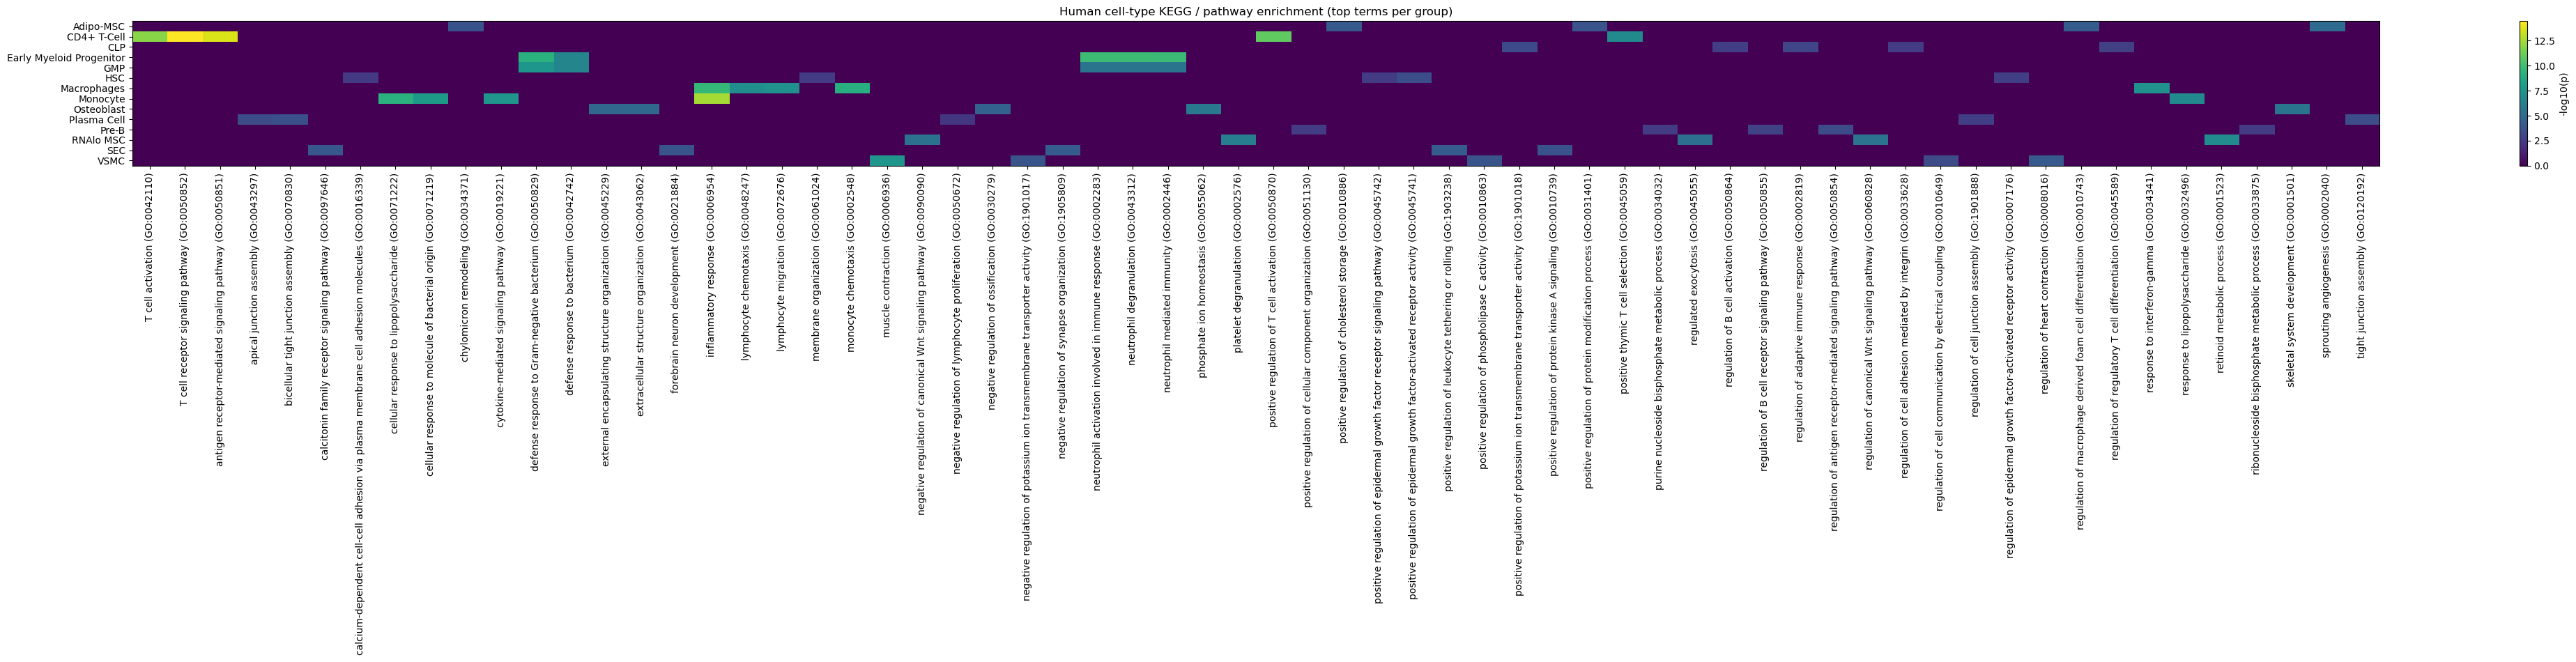

In [7]:
import numpy as np
import matplotlib.pyplot as plt

if not human_enrich.empty:
    print("Columns in human_enrich:", human_enrich.columns.tolist())

    df = human_enrich.copy()

    # --- figure out column names dynamically ---

    # 1) term / pathway name column
    term_col_candidates = [c for c in df.columns if "term" in c.lower() or "name" in c.lower()]
    if not term_col_candidates:
        raise ValueError("Could not find a column for pathway term/name in human_enrich.")
    term_col = term_col_candidates[0]

    # 2) p-value column
    pval_candidates = [c for c in df.columns if "p-value" in c.lower() or "p_value" in c.lower() or c.lower() == "pval"]
    if not pval_candidates:
        raise ValueError("Could not find a p-value column in human_enrich.")
    pval_col = pval_candidates[0]

    # 3) which column (if any) encodes the gene set / library (KEGG vs GO)
    lib_col_candidates = [c for c in df.columns if "library" in c.lower() or "gene_set" in c.lower() or "geneset" in c.lower()]
    lib_col = lib_col_candidates[0] if lib_col_candidates else None

    # --- compute -log10(p) ---
    df["-log10_p"] = -np.log10(df[pval_col].astype(float).replace(0, np.nan))

    # --- optional: restrict to KEGG if we can detect libraries ---
    if lib_col is not None:
        # keep only KEGG rows
        df = df[df[lib_col].astype(str).str.contains("KEGG", case=False, na=False)]

    # if you only used KEGG_2021_Human in enrichr, df is already KEGG-only

    # --- for each cell-type group, keep top N pathways ---
    N = 5
    if "group" not in df.columns:
        raise ValueError("Expected a 'group' column indicating cell types in human_enrich.")

    kegg_top = (
        df.sort_values("-log10_p", ascending=False)
          .groupby("group")
          .head(N)
    )

    # --- pivot to matrix: rows = cell types, columns = pathways ---
    heat = kegg_top.pivot_table(
        index="group",
        columns=term_col,
        values="-log10_p",
        aggfunc="max",
        fill_value=0,
    )

    # --- plot heatmap ---
    plt.figure(figsize=(0.6 * heat.shape[1] + 4, 0.4 * heat.shape[0] + 4))
    im = plt.imshow(heat.values, aspect="auto")

    plt.xticks(range(heat.shape[1]), heat.columns, rotation=90)
    plt.yticks(range(heat.shape[0]), heat.index)

    plt.colorbar(im, label="-log10(p)")
    plt.title("Human cell-type KEGG / pathway enrichment (top terms per group)")
    plt.tight_layout()
    plt.show()
